# Acessando a nuvem de pontos LiDAR 3D da cidade de São Paulo com PDal pelo serviço Entiwine

Nesse notebook vamos explorar alguns recuros da nuvem de pontos LiDAR 3D da cidade de São Paulo utilizando Python e a biblioteca PDal que vão acessar diretamente os dados disponibilizados pelo serviço Entwine. 
Dessa forma não vamos ter que fazer download dos arquivos LAZ o que pode ser vantajoso em alguns casos.

## Escolhendo uma região de interesse

Para esse exemplo vamos utilizar o parque do Ibirapuera como área de interesse para trabalhar os dados. Para deixar esse exercício ainda mais interessante não vamos fazer o download da feição do parque do Ibirapuera. Para obter a sua geometria vamos acessar o serviço WFS do GeoSampa

In [1]:
from owslib.wfs import WebFeatureService

url_wfs = 'http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/wfs'
wfs = WebFeatureService(url_wfs, version='2.0.0')

In [2]:
wfs['geoportal:parque_municipal'].abstract

'Parques municipais existentes, que atendem a pelo menos duas das seguintes condições: a) Possui decreto de criação; b) Administrado por SVMA; c) Projeto desenvolvido por SVMA.'

In [3]:
list(wfs.contents)

['geoportal:equipamento_saude_abrangencia_ubs',
 'geoportal:patrimonio_cultural_acervo_tombado',
 'geoportal:acidente_cet',
 'geoportal:equipamento_saude_ambulatorios_especializados',
 'geoportal:equipamento_ccz',
 'geoportal:arvore',
 'geoportal:arruamento_regularizado',
 'geoportal:equipamento_assistencia_social',
 'geoportal:bacia_hidrografica',
 'geoportal:patrimonio_cultural_bem_registrado',
 'geoportal:patrimonio_cultural_bem_tombado',
 'geoportal:patrimonio_cultural_bem_arqueologico',
 'geoportal:equipamento_cultura_bibliotecas',
 'geoportal:equipamento_bom_prato',
 'geoportal:equipamento_bombeiros',
 'geoportal:equipamento_cat',
 'geoportal:equipamento_educacao_ceu',
 'geoportal:cartorio_registro_imovel',
 'geoportal:equipamento_casas_mediacao',
 'geoportal:equipamento_cemiterio',
 'geoportal:equipamento_central_triagem_cooperativa',
 'geoportal:equipamento_central_triagem_mecanizada',
 'geoportal:equipamento_esporte_centro_esportivo',
 'geoportal:centro_referencia_assistencia_

In [4]:
wfs.get_schema('geoportal:parque_municipal')

{'properties': {'cd_identificador_parque_municipal': 'decimal',
  'nm_parque': 'string',
  'qt_area': 'decimal'},
 'required': ['cd_identificador_parque_municipal'],
 'geometry': '3D Polygon',
 'geometry_column': 'ge_poligono'}

In [5]:
todos_parques = wfs.getfeature(typename='geoportal:parque_municipal', outputFormat='application/json')

In [6]:
import json
parques = json.load(todos_parques)

In [7]:
modernista = list(filter(lambda x: x['properties']['nm_parque'] == 'CASA MODERNISTA', parques['features']))

In [8]:
modernista

[{'type': 'Feature',
  'id': 'parque_municipal.9',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[333382.3471999997, 7389586.9451],
     [333385.6372999996, 7389584.5456],
     [333388.3337000003, 7389581.8061],
     [333391.84640000015, 7389577.0871],
     [333396.1013000002, 7389570.9283],
     [333398.7977, 7389567.0891],
     [333401.6096000001, 7389562.6899],
     [333404.00090000033, 7389558.3908],
     [333405.78199999966, 7389554.3116],
     [333408.2062999997, 7389547.9229],
     [333410.21829999983, 7389541.6341],
     [333412.0323999999, 7389534.3456],
     [333413.64859999996, 7389527.387],
     [333416.91390000004, 7389510.2504],
     [333417.9528999999, 7389498.9626],
     [333423.13129999954, 7389474.3275],
     [333424.73929999955, 7389467.2589],
     [333424.36000000034, 7389465.0394],
     [333422.7520000003, 7389462.9198],
     [333420.01439999975, 7389461.3301],
     [333415.62760000024, 7389460.7302],
     [333407.76099999994, 7389461.5301],
     [333388.55

In [9]:
from shapely.geometry import Polygon
polygon = Polygon(modernista[0]['geometry']['coordinates'][0])

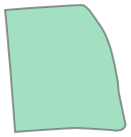

In [10]:
display(polygon)

## Acessando a nuvem de pontos LiDAR da região de interesse

Agora que já temos o polígono da região de interesse podemos carregar os pontos a partir do serviço EntWine

In [11]:
import pdal

In [12]:
bounds = polygon.bounds

In [13]:
cropper = [
    {
      "type": "readers.ept",
      "filename": "https://ept-m3dc-pmsp.s3-sa-east-1.amazonaws.com/ept.json",
      "bounds": str(([bounds[0], bounds[2]],[bounds[1], bounds[3]]))
    },
    {   "type":"filters.crop",
        'polygon':polygon.wkt
    },
    {   
        "type":"filters.hag_delaunay"
#     },
#     {   "type":"filters.eigenvalues",
#         "knn":16
    },
#     {   "type":"filters.normal",
#         "knn":16
#     },
#     {
#         "type":"filters.cluster"
#     },
]
# json.dumps(cropper)
pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

CPU times: user 4.49 s, sys: 105 ms, total: 4.59 s
Wall time: 4.29 s
Pipeline selected 324405 points (25.6 pts/m2)


In [14]:
pipeline.schema

{'schema': {'dimensions': [{'name': 'X', 'size': 8, 'type': 'floating'},
   {'name': 'Y', 'size': 8, 'type': 'floating'},
   {'name': 'Z', 'size': 8, 'type': 'floating'},
   {'name': 'Intensity', 'size': 2, 'type': 'unsigned'},
   {'name': 'ReturnNumber', 'size': 1, 'type': 'unsigned'},
   {'name': 'NumberOfReturns', 'size': 1, 'type': 'unsigned'},
   {'name': 'ScanDirectionFlag', 'size': 1, 'type': 'unsigned'},
   {'name': 'EdgeOfFlightLine', 'size': 1, 'type': 'unsigned'},
   {'name': 'Classification', 'size': 1, 'type': 'unsigned'},
   {'name': 'ScanAngleRank', 'size': 4, 'type': 'floating'},
   {'name': 'UserData', 'size': 1, 'type': 'unsigned'},
   {'name': 'PointSourceId', 'size': 2, 'type': 'unsigned'},
   {'name': 'GpsTime', 'size': 8, 'type': 'floating'},
   {'name': 'Red', 'size': 2, 'type': 'unsigned'},
   {'name': 'Green', 'size': 2, 'type': 'unsigned'},
   {'name': 'Blue', 'size': 2, 'type': 'unsigned'},
   {'name': 'OriginId', 'size': 4, 'type': 'unsigned'},
   {'name': '

In [15]:
import pandas as pd
arr = pipeline.arrays[0]
df = pd.DataFrame(arr)
# print(df.head().to_latex(index=False))
df.head()


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue,OriginId,HeightAboveGround
0,333372.24,7389562.82,811.69,16,2,2,0,0,5,18.0,15,31,1.763125e+08,21760,26112,28672,2752,15.203997
1,333398.99,7389463.42,830.64,22,1,2,1,0,5,2.0,32,31,1.763123e+08,12800,20992,26112,2752,31.370000
2,333404.38,7389526.79,830.11,32,1,2,1,0,5,-2.0,33,31,1.763123e+08,11520,18944,23040,2752,32.971534
3,333334.99,7389527.05,801.13,4,2,2,0,0,19,3.0,0,31,1.763123e+08,28160,33280,31232,2752,-0.128636
4,333339.30,7389535.53,819.48,10,1,2,1,0,5,3.0,19,31,1.763123e+08,8448,13312,20224,2752,18.525098


In [16]:
df.dtypes

X                    float64
Y                    float64
Z                    float64
Intensity             uint16
ReturnNumber           uint8
NumberOfReturns        uint8
ScanDirectionFlag      uint8
EdgeOfFlightLine       uint8
Classification         uint8
ScanAngleRank        float32
UserData               uint8
PointSourceId         uint16
GpsTime              float64
Red                   uint16
Green                 uint16
Blue                  uint16
OriginId              uint32
HeightAboveGround    float64
dtype: object

In [17]:
df.Classification.unique()

array([ 5, 19,  2, 20,  6], dtype=uint8)

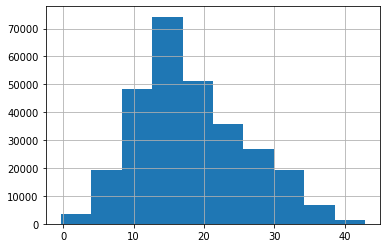

In [18]:
df[df.Classification == 5].HeightAboveGround.hist()

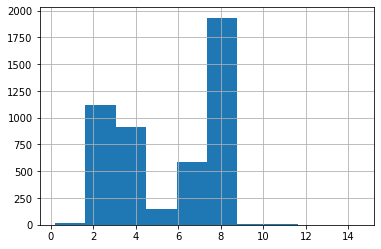

In [19]:
df[df.Classification == 6].HeightAboveGround.hist()

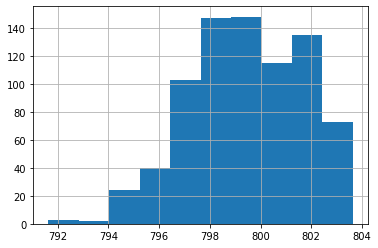

In [20]:
df[df.Classification == 2].Z.hist()

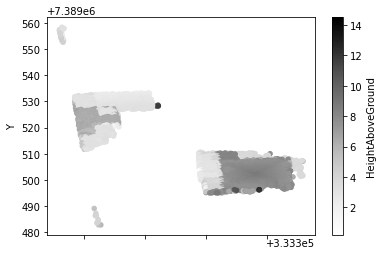

In [21]:
df[df.Classification == 6].plot.scatter(x='X', y='Y', c='HeightAboveGround')

In [22]:
bd = df[df.Classification == 6]
bd['xy'] = list(map(lambda x: (((x[1].X * 2).round() / 2), ((x[1].Y * 2).round() / 2)) , bd.iterrows()))

/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
len(bd['xy'].unique())/4

374.25

In [24]:
sum(bd.groupby('xy').max().HeightAboveGround)/4

2081.455610171509

## Visualizando dados

In [25]:
# Reduzindo valores a mínimos para poderem ser visualizados

df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']] - df[['X', 'Y', 'Z']].min()

In [26]:
gd = df[df.Classification == 2]
bd = df[df.Classification == 6]
vg = df[df.Classification == 5]

In [27]:
bd[['X', 'Y', 'Z']] = (bd[['X', 'Y', 'Z']] * 2).round()/2

/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


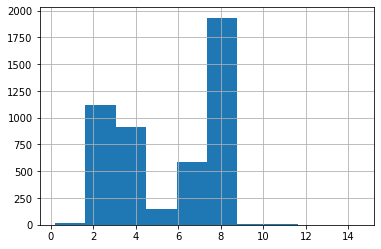

In [28]:
bd.HeightAboveGround.hist()

In [29]:
bd[bd.ClusterID == 1].HeightAboveGround.hist()

AttributeError: 'DataFrame' object has no attribute 'ClusterID'

In [ ]:
bd.HeightAboveGround.hist()

In [ ]:
bd.groupby('ClusterID').size()

In [ ]:
import ipyvolume as p3 

fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='grey', size=.2)
# ground = p3.scatter(gd['Y'], gd['Z'], gd['X'], color='grey', size=.2)
# building = p3.scatter(bd['Y'], bd['Z'], bd['X'], color='orange', size=.3)
# vegetation = p3.scatter(vg['Y'], vg['Z'], vg['X'], color='green', size=.1)
p3.squarelim()
p3.show()

In [ ]:
all_points.visible = False

In [ ]:

building = p3.scatter(bd[bd.ClusterID == 1]['Y'], bd[bd.ClusterID == 1]['Z'], bd[bd.ClusterID == 1]['X'], color='orange', marker='box', size=0.5, grow_limits=False)
fig.scatters.append(building)

In [ ]:
building3 = p3.scatter(bd[bd.ClusterID == 3]['Y'], bd[bd.ClusterID == 3]['Z'], bd[bd.ClusterID == 3]['X'], color='red', marker='box', size=0.5, grow_limits=False)
fig.scatters.append(building3)

In [ ]:
building733 = p3.scatter(bd[bd.ClusterID == 733]['Y'], bd[bd.ClusterID == 733]['Z'], bd[bd.ClusterID == 733]['X'], color='white', marker='box', size=0.5, grow_limits=False)
fig.scatters.append(building733)

In [ ]:
vegetation = p3.scatter(vg['Y'], vg['Z'], vg['X'], color='green', size=.1, grow_limits=False)
fig.scatters.append(vegetation)

In [ ]:
import scipy.spatial

ground_delaunay = scipy.spatial.Delaunay(gd[['X', 'Y']])
ground_surface = p3.plot_trisurf(gd.Y, gd.Z, gd.X, ground_delaunay.simplices, color='grey')
fig.meshes.append(ground_surface)

## Trabalhando com o Open3D

In [ ]:
import open3d as o3d

In [ ]:
df[['X', 'Y', 'Z']].to_numpy()

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(df[['X', 'Y', 'Z']].to_numpy())
# pcd.colors = o3d.utility.Vector3dVector(df[['Red', 'Green', 'Blue']].to_numpy())

In [ ]:
o3d.visualization.draw_geometries([pcd])

## Contando cada árvore

Agora vamos tentar aplicar um método para contar as árvores

In [ ]:
# https://gis.stackexchange.com/questions/255300/finding-tree-canopy-width-using-pdal
    
#     filters.approximatecoplanar
#     filters.estimaterank

# Tree top detection using local maxima filtering: aparameter sensitivity analysis
# https://hal.archives-ouvertes.fr/hal-00523245/document

In [ ]:

import numpy as np

def local_max(coords, radius, density_threshold=0):
    '''
    Find local maxima of points in a pointcloud.
    '''
    max_box = coords.copy()
    for i in range(2):
        max_box['X{}'.format(i)] = ((coords['X']/radius + i) /2).astype(int)*2
        max_box['Y{}'.format(i)] = ((coords['Y']/radius + i) /2).astype(int)*2
    max_box['X_'] = (coords['X']/radius).astype(int)
    max_box['Y_'] = (coords['Y']/radius).astype(int)
    for i in range(2):
        for j in range(2):
            max_box[str(i)+str(j)] = max_box.groupby(['X{}'.format(i), 'Y{}'.format(j)])['Z'].transform(np.max)
    density = max_box.groupby(['X_','Y_'])['Z'].transform(len)
    is_max = (max_box['00'] == max_box['10']) & (max_box['10'] == max_box['01']) & (max_box['01'] == max_box['11']) & (max_box['11'] == coords['Z'])
    return coords[is_max & (density >= (density_threshold))]

In [ ]:
lep = local_max(vg[['X','Y','Z','HeightAboveGround']], radius=3, density_threshold=0)

In [ ]:
lep

In [ ]:
treetop_spheres = p3.scatter(lep['Y'], lep['Z'], lep['X'], color='red', size=2, marker='sphere', grow_limits=False)
fig.scatters.append(treetop_spheres)